In [1]:
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace

## Creating the circuit

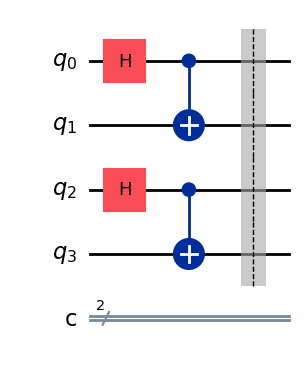

In [18]:
#Creation of entangled pairs
qc = QuantumCircuit(4,2)
qc.h(0)
qc.h(2)
qc.cx(0,1)
qc.cx(2,3)
qc.barrier()
qc.draw('mpl')

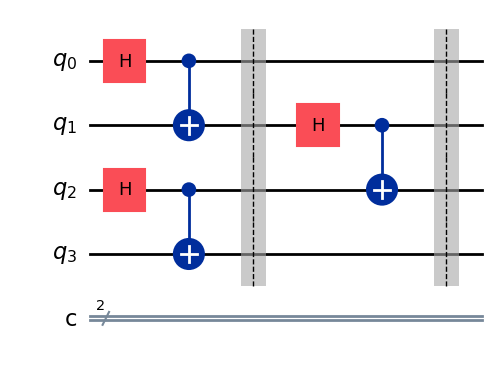

In [19]:
#Performing Discrete time Quantum Walk on the internal node's qubits
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.draw('mpl')

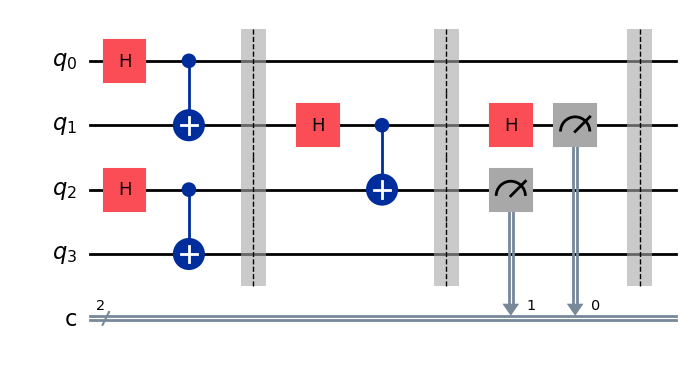

In [20]:
# Measurement on the internal node
qc.h(1)
qc.measure(1,0)
qc.measure(2,1)
qc.barrier()
qc.draw('mpl')

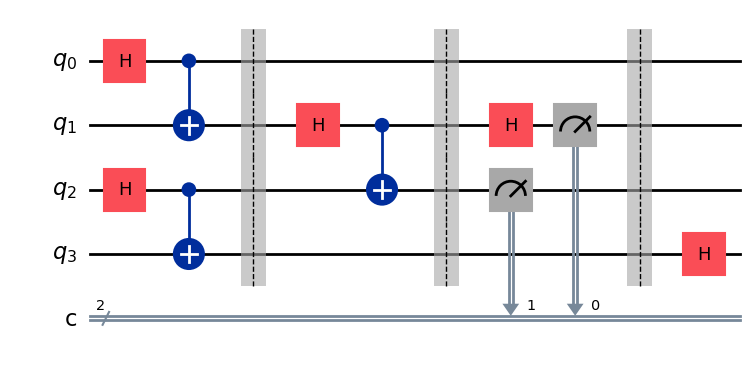

In [21]:
#Post measurement local operation
qc.h(3)
qc.draw('mpl')

## Getting pre measurement ckt

In [22]:

qc_unitary = QuantumCircuit(qc.num_qubits)

for inst, qargs, cargs in qc.data:
    if inst.name != "measure":
        qc_unitary.append(inst, qargs)

psi = Statevector.from_instruction(qc_unitary)


C:\Users\jyoti\AppData\Local\Temp\ipykernel_13908\1716539994.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


In [23]:
from qiskit.quantum_info import DensityMatrix
rho = DensityMatrix(psi)


## Post Selection Method

In [24]:
import numpy as np

# psi already computed
rho = DensityMatrix(psi)

# projector |00><00| on qubits q1,q2
proj_00 = DensityMatrix.from_label('00').to_operator()

rho_post = rho.evolve(proj_00, qargs=[1,2])

# renormalize
rho_post = rho_post / np.trace(rho_post.data)

In [25]:
# trace out measured qubits
rho_end = partial_trace(rho_post, [1,2])

In [26]:
from qiskit.quantum_info import Statevector, state_fidelity

def bell_state(label):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    if label == "phi-":
        qc.z(1)
    elif label == "psi+":
        qc.x(1)
    elif label == "psi-":
        qc.x(1)
        qc.z(1)
    return Statevector.from_instruction(qc)

bells = {
    "phi+": bell_state("phi+"),
    "phi-": bell_state("phi-"),
    "psi+": bell_state("psi+"),
    "psi-": bell_state("psi-")
}


##  Calculating Fidelity (Ideal Condition)

In [27]:
for name, bell in bells.items():
    print(name, state_fidelity(rho_end, bell))


phi+ 0.9999999999999998
phi- 0.0
psi+ 9.071053470133372e-35
psi- 0.0


In [28]:
# To confirm that the non zero psi plus fidelity is not physical error

print("Trace:", np.trace(rho_end.data))
print("Purity:", np.trace(rho_end.data @ rho_end.data))


Trace: (1+0j)
Purity: (1+0j)


## Feed Forward Method

In [40]:
qc_ff = qc.copy()

## Applying Feed-Forward Logic

In [41]:
# If c[1] == 1 → apply X
with qc_ff.if_test((qc_ff.clbits[1], 1)):
    qc_ff.z(3)

# If c[0] == 1 → apply Z
with qc_ff.if_test((qc_ff.clbits[0], 1)):
    qc_ff.x(3)





In [42]:
from qiskit_aer import AerSimulator

sim = AerSimulator(method="density_matrix")

qc_ff.save_density_matrix()
result = sim.run(qc_ff, shots=1).result()

rho_full = result.data(0)["density_matrix"]

from qiskit.quantum_info import partial_trace
rho_end1 = partial_trace(rho_full, [1,2])


##  Calculating Fidelity (Ideal Condition)

In [43]:
for name, bell in bells.items():
    print(name, state_fidelity(rho_end1, bell))

phi+ 0.9999999999999998
phi- 0.0
psi+ -1.2325951644078307e-32
psi- 0.0


In [44]:
# To confirm that the non zero psi plus fidelity is not physical error

print("Trace:", np.trace(rho_end1.data))
print("Purity:", np.trace(rho_end1.data @ rho_end1.data))

Trace: (1+0j)
Purity: (1+0j)


In [ ]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import amplitude_damping_error, phase_damping_error


In [ ]:
gamma = 0.02   # amplitude damping probability (T1)
lam   = 0.03   # phase damping probability (T2)


In [ ]:
single_qubit_decoherence = (
    amplitude_damping_error(gamma)
    .compose(phase_damping_error(lam))
)

In [ ]:
noise_model = NoiseModel()

# 1-qubit gates → 1-qubit decoherence
noise_model.add_all_qubit_quantum_error(
    single_qubit_decoherence, ['h']
)

# 2-qubit gates → tensor product of 1-qubit decoherence
noise_model.add_all_qubit_quantum_error(
    single_qubit_decoherence.tensor(single_qubit_decoherence), ['cx']
)


In [ ]:
sim = AerSimulator(noise_model=noise_model)

bell_ckt = qc.copy()
qc.measure_all()

result = sim.run(qc, shots=5000).result()
counts = result.get_counts()


In [ ]:

plot_histogram(counts)